<a href="https://colab.research.google.com/github/denistoo749/Malaria-Cell-Classification/blob/main/malaria_cells_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Cell Classification

Develop a model which is able to classify whether a blood smear is uninfected or parasitized. using TensorFlow  and TensorFlow Hub.

## 1. Problem:
Classify whether a blood smear is uninfected or parasitized. using TensorFlow  and TensorFlow Hub.

## 2. Data:
The data we're using is from One of the datasets under the Tensorflow Image libraries is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.

https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip

## 3. Evaluation:
The evaluation is a file with prediction probabilties for each cell image of each test image.

## 4. Features:
Some information about the data:
* The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.


In [6]:
# Unzip zipped file uploaded to the Google Drive
# !unzip '/content/drive/MyDrive/Malaria Cell Classification/cell_images.zip' -d '/content/drive/MyDrive/Malaria Cell Classification/'

## Getting Workspace ready:
* Import tensorflow ✅
* Import TensorFlow Hub ✅
* Make sure we're using a GPU ✅



In [11]:
# Import necessary tools
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
print(f'TF version: {tf.__version__}')
print(f'TF Hub version: {hub.__version__}')

# Check for GPU availability
print('GPU', 'avilability (YESSSS!!!!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

TF version: 2.15.0
TF Hub version: 0.16.1
GPU not available :(


Delete Thumbs.db file

In [9]:
# import os

# # Define folder paths
# folder_paths = [
#     "/content/drive/MyDrive/Malaria Cell Classification/cell_images/Uninfected",
#     "/content/drive/MyDrive/Malaria Cell Classification/cell_images/Parasitized"
# ]

# # Iterate over folder paths
# for folder_path in folder_paths:
#     thumbs_db_path = os.path.join(folder_path, "Thumbs.db")
#     # Check if the file exists before attempting to delete it
#     if os.path.exists(thumbs_db_path):
#         os.remove(thumbs_db_path)
#         print(f"Thumbs.db file deleted: {thumbs_db_path}")
#     else:
#         print(f"Thumbs.db file not found in {folder_path}.")

# Preprocessing images (Turning images into Tensors)
To preprocess our images into Tensors we're going to write a function which does a few things:
* Take an image filepath as input
* Use a TensorFlow to read the file and save it to a variable, image
* Turn our image into Tensors
* Resize the image to be a shape of (224, 224)
* Return the modified image

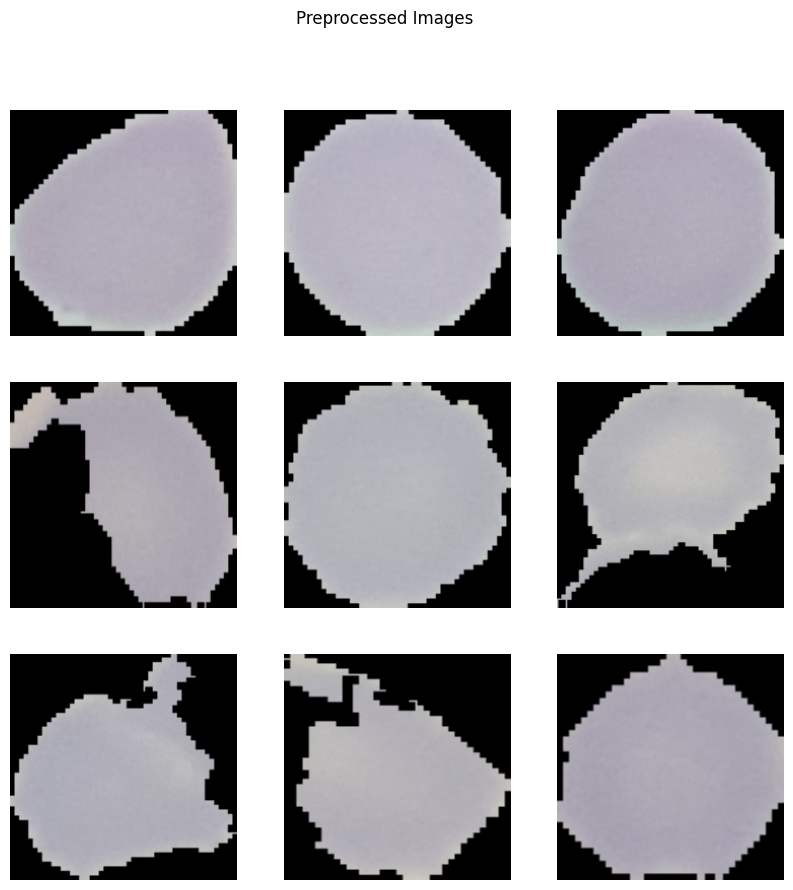

In [15]:
# Set Up Directories
data_dir = '/content/drive/MyDrive/Malaria Cell Classification/cell_images'

# Preprocess Image Function
def preprocess_image(image_path):
    # Read the image file
    image = tf.io.read_file(image_path)
    # Decode the image to tensors
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the desired shape
    image = tf.image.resize(image, [224, 224])
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image

# Get Image Paths
def get_image_paths(data_dir):
    image_paths = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths(data_dir)

# Create a Dataset from Image Paths
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Map the Preprocessing Function to the Dataset
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Display a Few Images
def display_dataset_images(dataset, title):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(dataset.take(9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

display_dataset_images(image_dataset, "Preprocessed Images")

Create Dataset and Labels

In [16]:
import pathlib

data_root = pathlib.Path(data_dir)
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = {name: index for index, name in enumerate(label_names)}

all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

# Convert to TensorFlow datasets
image_dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

Map Preprocessing Function to Dataset

In [17]:
def load_and_preprocess_image(path, label):
    return preprocess_image(path), label

image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Prepare Data for Training

In [18]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Shuffle and batch the data
image_dataset = image_dataset.shuffle(buffer_size=len(all_image_paths))
image_dataset = image_dataset.batch(BATCH_SIZE)
image_dataset = image_dataset.prefetch(buffer_size=AUTOTUNE)

Build the Model

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(label_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

Train the Model

In [ ]:
EPOCHS = 10

history = model.fit(
    image_dataset,
    epochs=EPOCHS
)

Epoch 1/10


Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Malaria Cell Classification/model.keras')

Evaluate the Model

In [ ]:
# Example: Evaluate on a validation dataset
# Assuming validation_dataset is prepared similarly as image_dataset

validation_dataset = ...  # Prepare your validation dataset

loss, accuracy = model.evaluate(validation_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

Inference on New Images

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(model, img_path):
    img = preprocess_image(img_path)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    predicted_label = label_names[np.argmax(prediction)]
    return predicted_label

# Example usage
img_path = '/content/drive/MyDrive/path_to_your_images/some_image.jpg'
predicted_label = predict_image(model, img_path)
print(f'Predicted label: {predicted_label}')